# Introduction to Autoencoders


## Supervised and Unsupervised Learning


### Supervised Learning


In previous lessons, we only covered supervised learning. This involves training data that includes both an input **x** and an output **y**. The model takes **x** as input and predicts **y**.
For example, with MNIST, we had an image **x** and a label **y** representing a digit between 0 and 9. In segmentation, we used an image **x** and a mask **y** as output.


### Unsupervised Learning


In unsupervised learning, the data is not labeled, meaning we only have **x** without **y**. In this case, we cannot predict a specific value, but we can train a model to group similar elements (known as clustering).
In this course, we will focus on unsupervised anomaly detection. The idea is to train a model on a certain type of data and then use it to detect elements that differ from the training set.


## Autoencoder


### Architecture


The basic model for this type of task is called an "autoencoder". Its architecture is similar to that of the U-Net we previously saw.
Here is the classic architecture of an autoencoder:


As you can see, it has a "hourglass" shape. The idea of an autoencoder is to create a compressed representation of the input data and reconstruct it from this representation. In fact, this model can also be used to compress data.


### Use for Unsupervised Anomaly Detection


For unsupervised anomaly detection, let's take an example. We train the autoencoder to reconstruct images of the digit 5. Once trained, it will perfectly reconstruct images of 5. If we want to detect whether an image is a 5 or another digit, we simply give it to the autoencoder. By analyzing the quality of the reconstruction ($image_{base} - image_{recons}$), we can determine if it is a 5 or not.
The following image illustrates this principle:


## Practical Application on MNIST


To illustrate what has been described, we will train an autoencoder to reconstruct the digit 5 using PyTorch.


In [14]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

### Creating Training and Test Datasets


In [15]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

We have retrieved our training/validation and test datasets. We want to keep only the 5s in the training dataset. To do this, we will remove elements that do not contain the digit 5.


In [16]:
# On récupere les indices des images de 5
indices = [i for i, label in enumerate(dataset.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
filtered_dataset = torch.utils.data.Subset(dataset, indices)

We can visualize a few images to verify that we only have 5s.


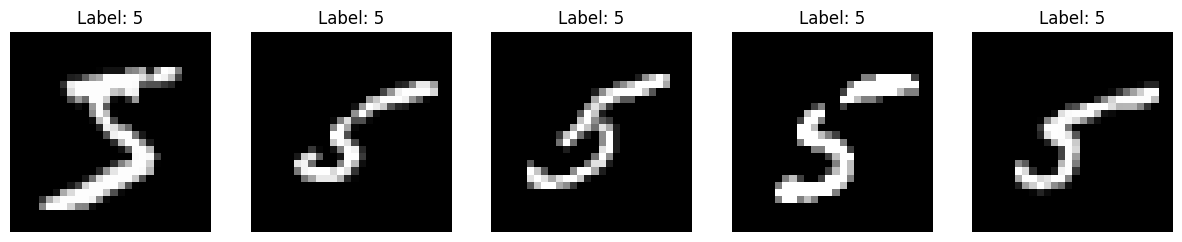

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  image, label = filtered_dataset[i]
  image = image.squeeze().numpy() 
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Label: {label}')
  axes[i].axis('off')
plt.show()

Now, let's split the dataset into training and validation parts, and then create our dataloaders.


In [18]:
train_dataset, validation_dataset=torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Creating the Autoencoder Model


For the MNIST dataset, a shallow architecture is sufficient to achieve good results.


In [19]:
class ae(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      nn.Linear(28 * 28, 512), 
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
    )
    self.decoder = nn.Sequential(
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28 * 28),
      nn.Sigmoid()
    )
  
  def forward(self,x):
    x=x.view(-1,28*28) 
    x = self.encoder(x)
    x = self.decoder(x)
    recons=x.view(-1,28,28)
    return recons

In [20]:
model = ae()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

ae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Nombre de paramètres 1132944


### Training the Model


For the loss function, we use MSELoss, which corresponds to the mean squared error defined by:
$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
where $N$ is the total number of pixels in the image, $y_i$ is the value of pixel $i$ in the original image, and $\hat{y}_i$ is the value of pixel $i$ in the reconstructed image.
This is a classic function to evaluate the quality of a reconstruction.


In [21]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.08228749781847
step 0 val loss 0.06261523813009262
step 1 train loss 0.06122465804219246
step 1 val loss 0.06214689463376999
step 2 train loss 0.06105153635144234
step 2 val loss 0.06189680099487305
step 3 train loss 0.06086035445332527
step 3 val loss 0.06180128455162048
step 4 train loss 0.0608210563659668
step 4 val loss 0.06169722229242325
step 5 train loss 0.06080913543701172
step 5 val loss 0.061976321041584015
step 6 train loss 0.060783520340919495
step 6 val loss 0.06190618872642517
step 7 train loss 0.06072703003883362
step 7 val loss 0.06161761283874512
step 8 train loss 0.06068740040063858
step 8 val loss 0.061624933034181595
step 9 train loss 0.060728199779987335
step 9 val loss 0.061608292162418365


Now, let's look at the reconstruction of images from the test dataset.


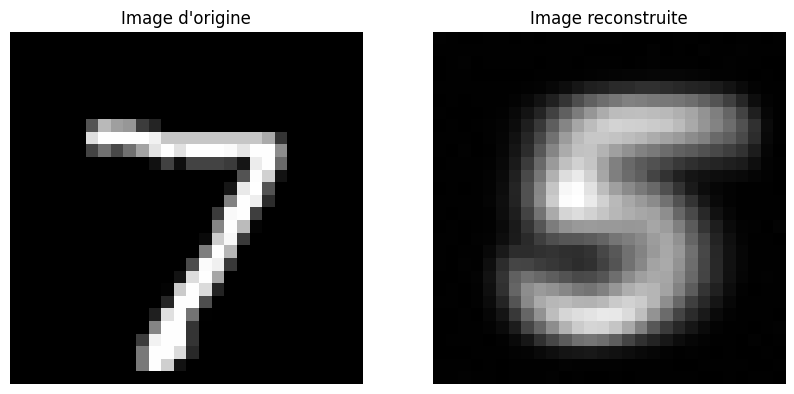

difference :  0.0687035545706749


In [23]:
images,_=next(iter(test_loader))

#Isolons un élément 
image=images[0].unsqueeze(0)
with torch.no_grad():
  recons=model(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image d'origine
axs[0].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Image d\'origine')
axs[0].axis('off')

# Image reconstruite
axs[1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title('Image reconstruite')
axs[1].axis('off')
plt.show()
print("difference : ", criterion(image,recons).item())

We notice that the reconstruction of the 7 is very poor, which allows us to deduce that it is an anomaly.
